# <font color="blue">Import Libraries</font>

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns = None # To display all the columns of a Dataframe.
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

# <font color="blue">2. Merge the Datasets</font>

* Merge the given datasets as<br>
&emsp; * Inpatient and Outpatient contains almost all similar columns and hence, can be concatenated. This would give a single dataset containing the details of both inpatient and outpatient details related to the claims.<br>
&emsp; * The resultant dataset can be combined with the Beneficiary dataset based on the Beneficiary Id to add the beneficiary related information to the dataset.<br>
&emsp; * Finally, the dataset can be merged with the Provider dataset to map the class label to decide whether the Provider is fraudulent or not.

In [ ]:
%%time
'''
Reading the data to discard any of the temporary columns created during the EDA.
'''
dataProvider = pd.read_csv('Data/Train-1542865627584.csv') # Mapping Dataset
dataBeneficiary = pd.read_csv('Data/Train_Beneficiarydata-1542865627584.csv') # Beneficiary Dataset
dataInpatient = pd.read_csv('Data/Train_Inpatientdata-1542865627584.csv') # Inpatient Dataset
dataOutpatient = pd.read_csv('Data/Train_Outpatientdata-1542865627584.csv') # Outpatient Dataset

Wall time: 5.03 s


In [ ]:
def combineDatasets(dataProvider, dataBeneficiary, dataInpatient, dataOutpatient):
    '''
    Combines the given datasets of Provider Class Label mapping, Beneficiary data, Inpatient and Outpatient claims data,
    and returns the combined dataset.
    
    Parameters:
    ----------
    dataProvider: pandas.core.frame.DataFrame
        DataFrame containing the Provider Unique Identifier and Class Label (in case of Train data).
    dataBeneficiary: pandas.core.frame.DataFrame
        DataFrame containing the Beneficiary related data
    dataInpatient: pandas.core.frame.DataFrame
        DataFrame containing the Inpatient claims related data
    dataOutpatient: pandas.core.frame.DataFrame
        DataFrame containing the Outpatient claims related data        
    '''
    
    # Concatenate the Inpatient and Outpatient dataset as these contain almost similar information
    dataConcat = pd.concat([dataInpatient, dataOutpatient])
    
    # Merge the above dataframe with the Beneficiary dataframe
    dataMerge = pd.merge(left=dataConcat, right=dataBeneficiary, on='BeneID')
    
    # Merge the above dataframe with the provider dataframe to add the Class Label.
    dataFinal = pd.merge(left=dataMerge, right=dataProvider, on='Provider')
    
    # Return the final dataframe
    return dataFinal

In [ ]:
%%time
# Call the function 'combineDatasets' for the datasets.
data = combineDatasets(dataProvider, dataBeneficiary, dataInpatient, dataOutpatient)

Wall time: 2.7 s


In [ ]:
print('Shape of the merged Dataset: ', data.shape)
print('Number of features in the merged Dataset: ', data.shape[1]-1)

Shape of the merged Dataset:  (558211, 55)
Number of features in the merged Dataset:  54


# <font color="blue">3. Data Preparation</font>

* Here, we will do some data cleanup, preprocessing and Featurization.

In [ ]:
data.info() # Print a concise summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 55 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   ClaimID                          558211 non-null  object 
 2   ClaimStartDt                     558211 non-null  object 
 3   ClaimEndDt                       558211 non-null  object 
 4   Provider                         558211 non-null  object 
 5   InscClaimAmtReimbursed           558211 non-null  int64  
 6   AttendingPhysician               556703 non-null  object 
 7   OperatingPhysician               114447 non-null  object 
 8   OtherPhysician                   199736 non-null  object 
 9   AdmissionDt                      40474 non-null   object 
 10  ClmAdmitDiagnosisCode            145899 non-null  object 
 11  DeductibleAmtPaid                557312 non-null  float64
 12  Di

In [ ]:
def dataCleanup(data):
    '''
    Cleans up the data in the given dataset and returns the cleaned dataset.
    This has been written by doing the analysis of each individual column values.
    TODO: Any kind of imputation is not done as part of this method and it will done by doing nvariate analysis of the 
    columns having null values.
    
    Parameter:
    ---------
    data: pandas.core.frame.DataFrame
        Dataframe to be cleaned up
    '''
    
    # -------------------------------Region : Beneficiary Columns-------------------------------------------------
    
    # 'Renal Disease Indicator' column.
    # RenalDiseaseIndicator column has two unique values: 0 and 'Y'. Replace the value of 'Y' with 1.
    data['RenalDiseaseIndicator'].replace(to_replace='Y', value=1, inplace=True)
    
    # 'Chronic Condition' columns
    # 'ChronicCond_' columns contains two unique values: 1 and 2. Replace the value of 2 with 0 to indicate 1 as 'Yes' 
    # and 0 as 'No'
    for chronicCol in [col for col in list(data.columns) if 'Chronic' in col]:
        data[chronicCol].replace(to_replace=2, value=0, inplace=True)
    
    # Rename the column 'County' as 'Country'
    data.rename(columns={'County': 'Country'}, inplace=True)    
    
    # -------------------------------End Region: Beneficiary Columns----------------------------------------------
    
    
    # -------------------------------Region : Inpatient and Outpatient Columns------------------------------------
    
    # Fill empty values of the 'DeductibleAmtPaid' feature as it is a numeric feature and has some empty values.
    data['DeductibleAmtPaid'].fillna(value=0, inplace=True)
    
    # -------------------------------End Region : Inpatient and Outpatient Columns--------------------------------
    
    
    # -------------------------------Region: Other columns -------------------------------------------------------
    
    # Drop the columns having all null values
    data.dropna(axis=1, how='all', inplace=True)
    
    # Replace the class label 'PotentialFraud' values. Replace 'Yes' with 1 and 'No' with 0.
    if ('PotentialFraud' in data.columns):
        
        data['PotentialFraud'].replace(to_replace=['Yes', 'No'], value=[1, 0], inplace=True)

    # -------------------------------End Region: Other columns ---------------------------------------------------

In [ ]:
%%time
# Call the function 'dataCleanup' to clean the data in the dataframe
dataCleanup(data)

Wall time: 3.26 s


In [ ]:
print('Shape of the Dataset: ', data.shape)

Shape of the Dataset:  (558211, 54)


## <font color="blue">3.1. Percentage of Null or Empty values</font>

* Check the percentage of null values for each column in the dataframe.
* Also, plot a heatmap to see the percentage of missing values in the dataframe.

In [ ]:
print('Percentage of missing values in the Dataframe (column wise):\n')
round((data.isna().sum()/data.shape[0])*100,2)

Percentage of missing values in the Dataframe (column wise):



BeneID                               0.00
ClaimID                              0.00
ClaimStartDt                         0.00
ClaimEndDt                           0.00
Provider                             0.00
InscClaimAmtReimbursed               0.00
AttendingPhysician                   0.27
OperatingPhysician                  79.50
OtherPhysician                      64.22
AdmissionDt                         92.75
ClmAdmitDiagnosisCode               73.86
DeductibleAmtPaid                    0.00
DischargeDt                         92.75
DiagnosisGroupCode                  92.75
ClmDiagnosisCode_1                   1.87
ClmDiagnosisCode_2                  35.04
ClmDiagnosisCode_3                  56.46
ClmDiagnosisCode_4                  70.52
ClmDiagnosisCode_5                  79.95
ClmDiagnosisCode_6                  84.88
ClmDiagnosisCode_7                  88.14
ClmDiagnosisCode_8                  90.43
ClmDiagnosisCode_9                  92.51
ClmDiagnosisCode_10               

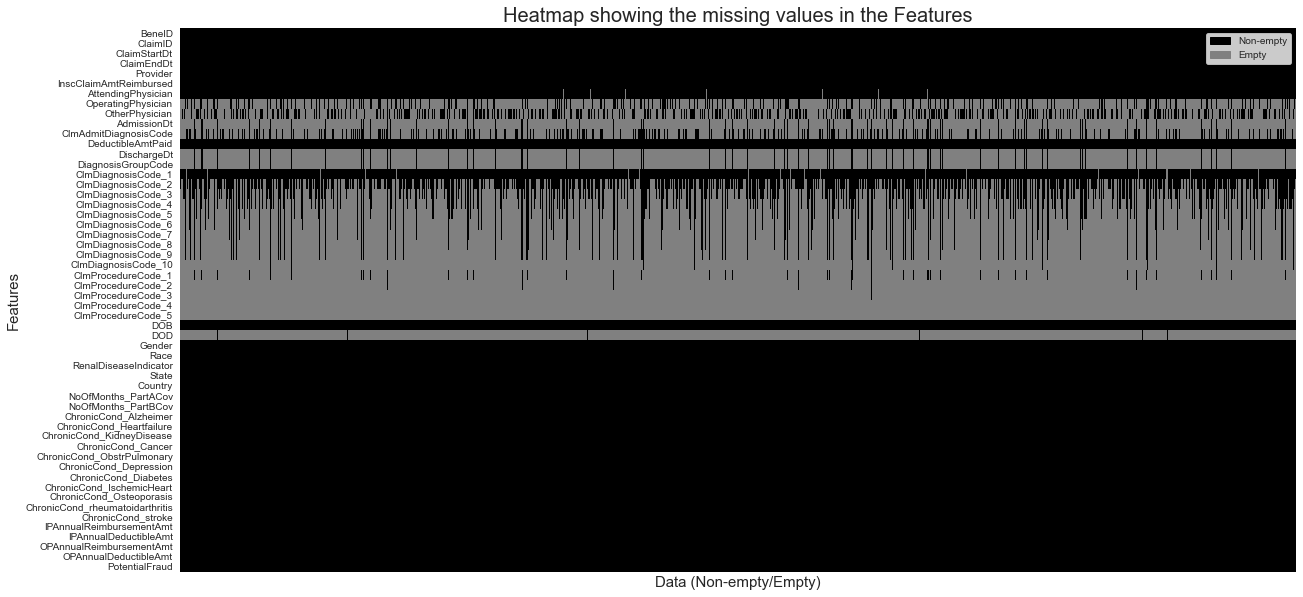

Wall time: 2min 31s


In [ ]:
%%time
# Plot heatmap
plt.figure(figsize=(20,10))
sns.heatmap(data.T.isnull(), cbar=False, yticklabels=True, xticklabels=False, cmap=['black', 'grey'])
blackPatch = mpatches.Patch(color='black', label='Non-empty')
greyPatch = mpatches.Patch(color='grey', label='Empty')
plt.legend(handles=[blackPatch, greyPatch], loc='upper right')
plt.xlabel('Data (Non-empty/Empty)', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title('Heatmap showing the missing values in the Features', fontsize=20)
plt.show()

#### Observation

* Few of the Diagnosis Code and Precedural Codes are having high percentage of empty values in the dataframe.
* The variables having more than 99.5% empty cells are:<br>
&emsp; 3. ClmProcedureCode_3<br>
&emsp; 4. ClmProcedureCode_4<br>
&emsp; 5. ClmProcedureCode_5<br>
* These columns can be removed as they have almost all empty cells and won't contribute much to the classification.

In [ ]:
# Set of columns to be removed
columnsToRemove = ['ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5']

In [ ]:
# Remove the above set of columns from the dataframe
data.drop(columns=columnsToRemove, inplace=True)

In [ ]:
print('Shape of the Dataset after removal of columns having more than 99% empty values: ', data.shape)

Shape of the Dataset after removal of columns having more than 99% empty values:  (558211, 51)


## <font color="blue">3.2. Plot Correlation Graph</font>

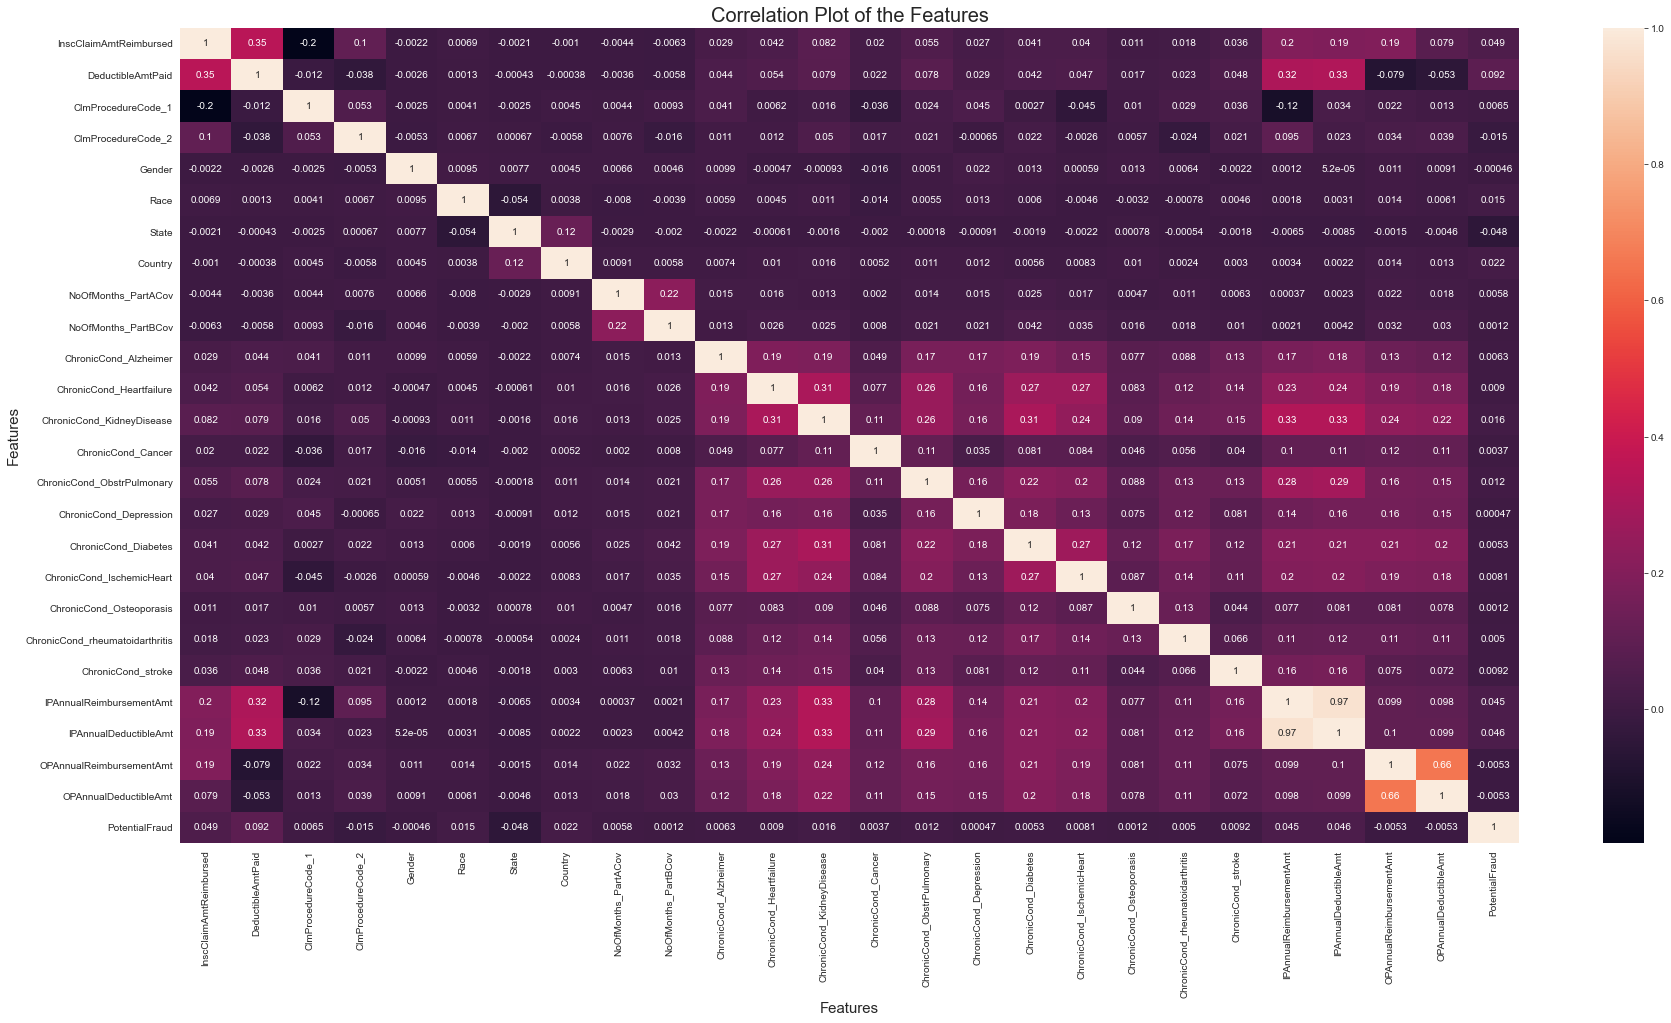

Wall time: 18 s


In [ ]:
%%time
plt.figure(figsize=(30,15))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.title('Correlation Plot of the Features', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

#### Observation

* We can see that the correlation coefficient of the below pair of features are more:<br>
&emsp; 1. IPAnnualReimbursementAmt and IPAnnualDeductibleAmt (0.97).<br>
&emsp; 2. OPAnnualReimbursementAmt and OPAnnualDeductibleAmt (0.66).<br>
* For now, let's not remove one of them because annual reimbursement amount and annual deductible amounts are related as:<br>
&emsp; * Total Claim Amount = Reimbursement Amount + Deductible Amount.<br>
&emsp; * Reimbursement Amount = Amount the Payer (Insurance Agency) pays for the claim.<br>
&emsp; * Deductible Amount = Amount the beneficiary has to pay as part of the claim.<br>
* Will do some Feature Engineering to get the total claim amount feature and other features, and recheck the correlation.

* Let's check the correlation of the features with the Class Label.

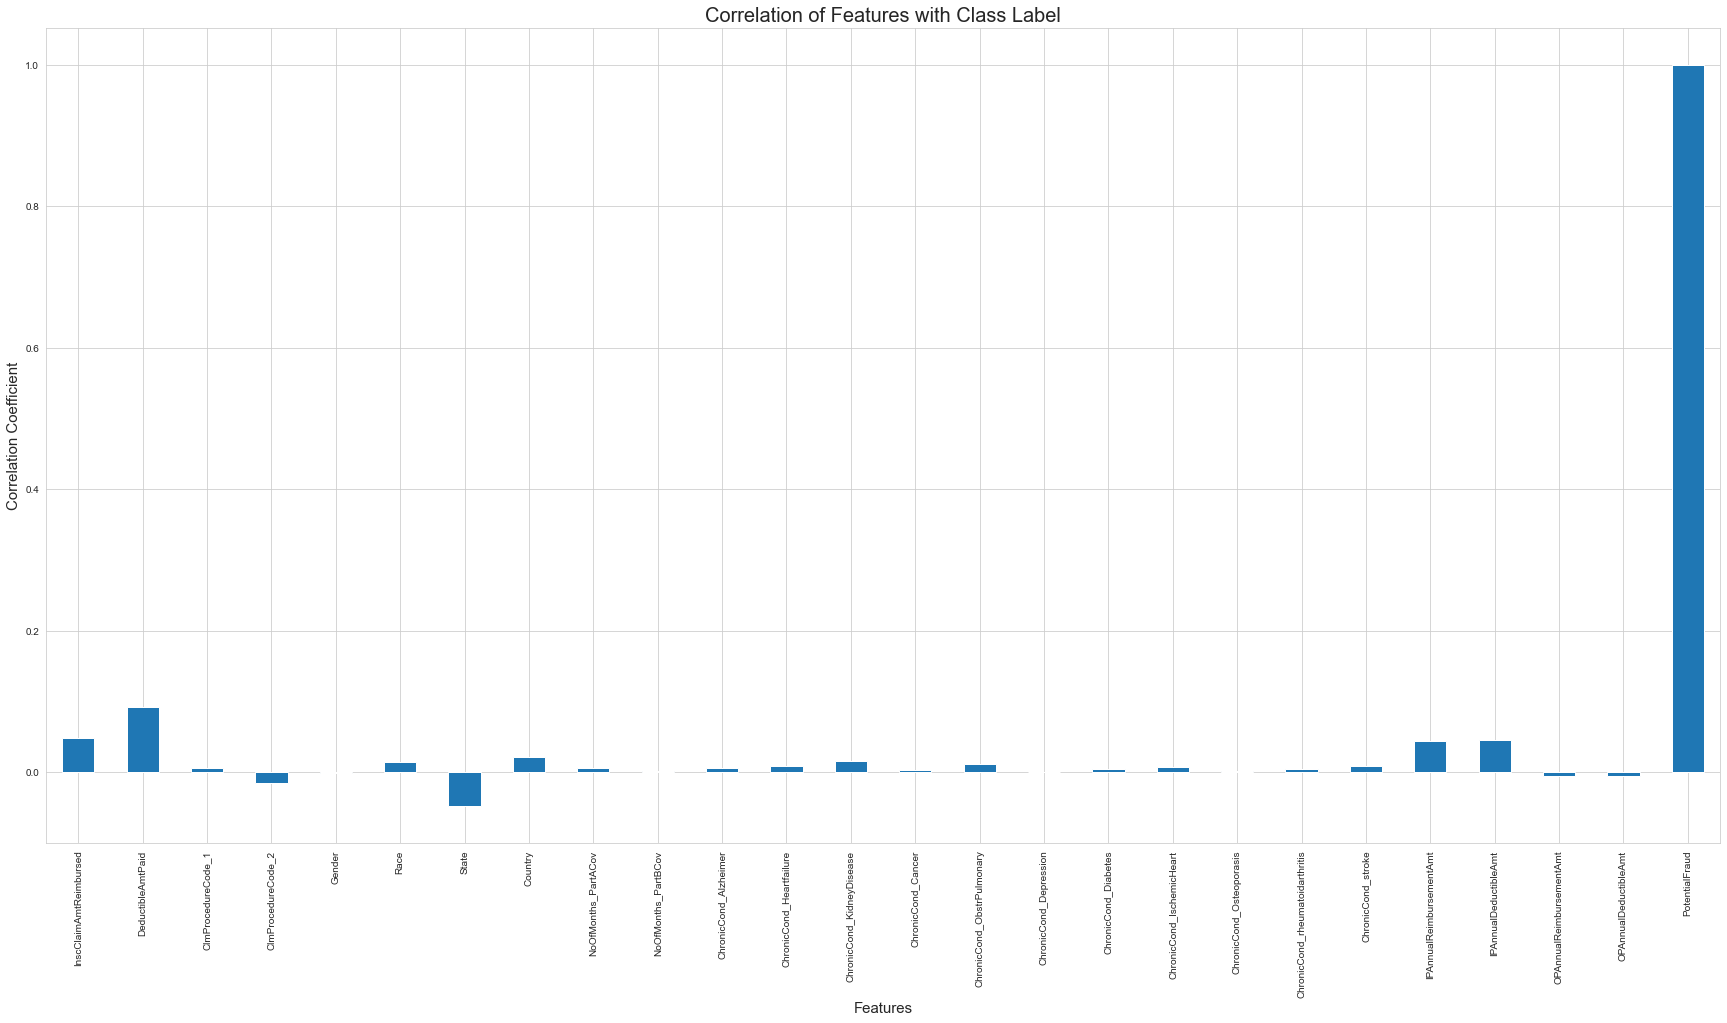

Wall time: 5.32 s


In [ ]:
%%time
plt.figure(figsize=(20,8))
data.corrwith(data['PotentialFraud'], method='spearman').plot.bar(figsize=(30,15), grid=True)
plt.title('Correlation of Features with Class Label', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation Coefficient', fontsize=15)
plt.show()

#### Observation

* As we can see that features 'Gender', 'NoOfMonths_PartACov', 'ChronicCond_Depression', 'ChronicCond_Osteoporasis' and 'OPAnnualReimbursementAmt' are very less correlated to the Class Label.
* We cannot directly remove these features considering these are not correlated with the Class Label because these features could be correlated to the Class Label in combination with other features.

## <font color="blue">3.3. Feature Engineering</font>

* Let's try to come with some new Features based on the domain research done.

### <font color="blue">3.3.1. New Features from Date Features</font>

* Here, we will generate new features from the date features:<br>
&emsp; 1. Claim Settlement Delay: Difference between the Claim End Date and Claim Start Date.<br>
&emsp; 2. Treatment Duration: Difference between Discharge Date and Admission Date.<br>
&emsp; 3. Age: Based on the DOB.<br>
&emsp; 4. IsDead: Based on the DOD.<br>

In [ ]:
# Date related columns
colDate = [col for col in data.columns if ('Dt' in col or 'DOB' in col or 'DOD' in col)]

print('Date related columns: ', colDate)

Date related columns:  ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt', 'DOB', 'DOD']


In [ ]:
# Convert these columns to DateTime Format
data[colDate] = data[colDate].apply(pd.to_datetime)

In [ ]:
# Generate new Feature 'ClaimSettlementDelay' (ClaimEndDt - ClaimStartDt)
data['ClaimSettlementDelay'] = (data['ClaimEndDt'] - data['ClaimStartDt']).dt.days

In [ ]:
# Generate new Feature 'TreatmentDuration' (DischargeDt - AdmissionDt)
data['TreatmentDuration'] = (data['DischargeDt'] - data['AdmissionDt']).dt.days
data['TreatmentDuration'].fillna(0, inplace=True) # Filling empty values with 0 because the features 
# 'DischargeDt' and 'AdmissionDt' exist only for Inpatient records.

data['TreatmentDuration'] = data['TreatmentDuration'].apply(int)

In [ ]:
maxDate = max(data['ClaimEndDt'].max(), data['DischargeDt'].max())
print('Maximum Claim End Date or Discharge Date: ', maxDate)

Maximum Claim End Date or Discharge Date:  2009-12-31 00:00:00


* As the maximum Claim End Date or Discharge Date is '2009-12-31', which implies that the dataset has the data till 2009.
* Hence for calculating the age of the beneficiary, we can calculate the age as of '2009-12-31' and not the current date.
* If the DOD value is present, the age will be calculated based on the DOD date.

In [ ]:
%%time
data['Age'] = data.apply(lambda x: round(((x['DOD'] - x['DOB']).days)/365) if pd.notnull(x['DOD'])
                         else round(((maxDate - x['DOB']).days)/365), axis=1)

Wall time: 1min 2s


In [ ]:
%%time
# Generate new Feature 'IsDead' based on whether there is a value in the DOD column or not
data['IsDead'] = data['DOD'].apply(lambda x: 1 if pd.notnull(x) else 0)

Wall time: 2.97 s


In [ ]:
# Remove the set of date columns from the dataframe
data.drop(columns=colDate, inplace=True)

In [ ]:
print('Shape of the Dataset after removal of date features and addition of new features: ', data.shape)

Shape of the Dataset after removal of date features and addition of new features:  (558211, 49)


In [ ]:
data.head()

,BeneID,ClaimID,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,Gender,Race,RenalDiseaseIndicator,State,Country,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,ClaimSettlementDelay,TreatmentDuration,Age,IsDead
0,BENE11001,CLM46614,PRV55912,26000,PHY390922,NaN,NaN,7866,1068.0,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,1,6,6,67,0
1,BENE16973,CLM565430,PRV55912,50,PHY365867,PHY327147,NaN,NaN,0.0,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,1,1,0,39,310,12,12,1,1,1,0,0,0,0,1,0,0,0,24000,2136,450,200,1,0,0,78,0
2,BENE17521,CLM34721,PRV55912,19000,PHY349293,PHY370861,PHY363291,45340,1068.0,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,NaN,7769.0,5849.0,2,1,0,39,230,12,12,1,1,1,0,1,0,0,1,0,0,0,19000,1068,100,20,1,12,12,96,0
3,BENE21718,CLM72336,PRV55912,17000,PHY334706,PHY334706,NaN,V5789,1068.0,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,NaN,9338.0,NaN,1,1,0,39,600,12,12,0,0,0,0,0,0,0,1,1,0,0,17000,1068,1050,540,1,18,18,87,0
4,BENE22934,CLM73394,PRV55912,13000,PHY390614,PHY323689,PHY363291,71946,1068.0,506,71535,71960,4019,V1202,4240,2449,2768,NaN,NaN,NaN,8154.0,NaN,2,1,0,39,280,12,12,0,1,0,0,1,0,1,1,1,1,0,27000,2136,450,160,1,4,4,80,0


### <font color="blue">3.3.2. New Features from Reimbursement Amount and Deductible Amount</font>

* Here, we will generate new features from the features:<br>
&emsp; * InscClaimAmtReimbursed, DeductibleAmtPaid, IPAnnualReimbursementAmt, IPAnnualDeductibleAmt, OPAnnualReimbursementAmt and OPAnnualDeductibleAmt.<br>
* TotalClaimAmount = InscClaimAmtReimbursed + DeductibleAmtPaid.
* IPTotalAmount = IPAnnualReimbursementAmt + IPAnnualDeductibleAmt.
* OPTotalAmount = OPAnnualReimbursementAmt + OPAnnualDeductibleAmt.

In [ ]:
# Fetch the features related to amount.
colAmt = [col for col in data.columns if 'Amt' in col]
colAmt

['InscClaimAmtReimbursed',
 'DeductibleAmtPaid',
 'IPAnnualReimbursementAmt',
 'IPAnnualDeductibleAmt',
 'OPAnnualReimbursementAmt',
 'OPAnnualDeductibleAmt']

In [ ]:
# Total Claim Amount = Insurance Claim Amount reimbursed + Deductible Amount paid by the Subscriber
data['TotalClaimAmount'] = data['InscClaimAmtReimbursed'] + data['DeductibleAmtPaid']

# Total Inpatient Amount = Inpatient Annual Amount reimbursed + Inpatient Annual Deductible Amount
data['IPTotalAmount'] = data['IPAnnualReimbursementAmt'] + data['IPAnnualDeductibleAmt']

# Total Outpatient Amount = Outpatient Annual Amount reimbursed + Outpatient Annual Deductible Amount
data['OPTotalAmount'] = data['OPAnnualReimbursementAmt'] + data['OPAnnualDeductibleAmt']

In [ ]:
# Remove the set of old amount features from the dataframe
data.drop(columns=colAmt, inplace=True)

In [ ]:
print('Shape of the Dataset after removal of old amount related features and addition of new features: ', data.shape)

Shape of the Dataset after removal of old amount related features and addition of new features:  (558211, 46)


### <font color="blue">3.3.3. New Features to indicate Inpatient and Outpatient</font>

* Here, we will generate a new feature called 'IsInpatient' having value 1 if the claim record is for Inpatient data and 0 if the claim record is for Outpatient data.
* As the feature 'DiagnosisGroupCode' exist only for Inpatient dataset, we will create the values for 'IsInpatient' based on whether is a value in the 'DiagnosisGroupCode' feature.

In [ ]:
data['IsInpatient'] = data['DiagnosisGroupCode'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [ ]:
print('Shape of the Dataset now: ', data.shape)

Shape of the Dataset now:  (558211, 47)


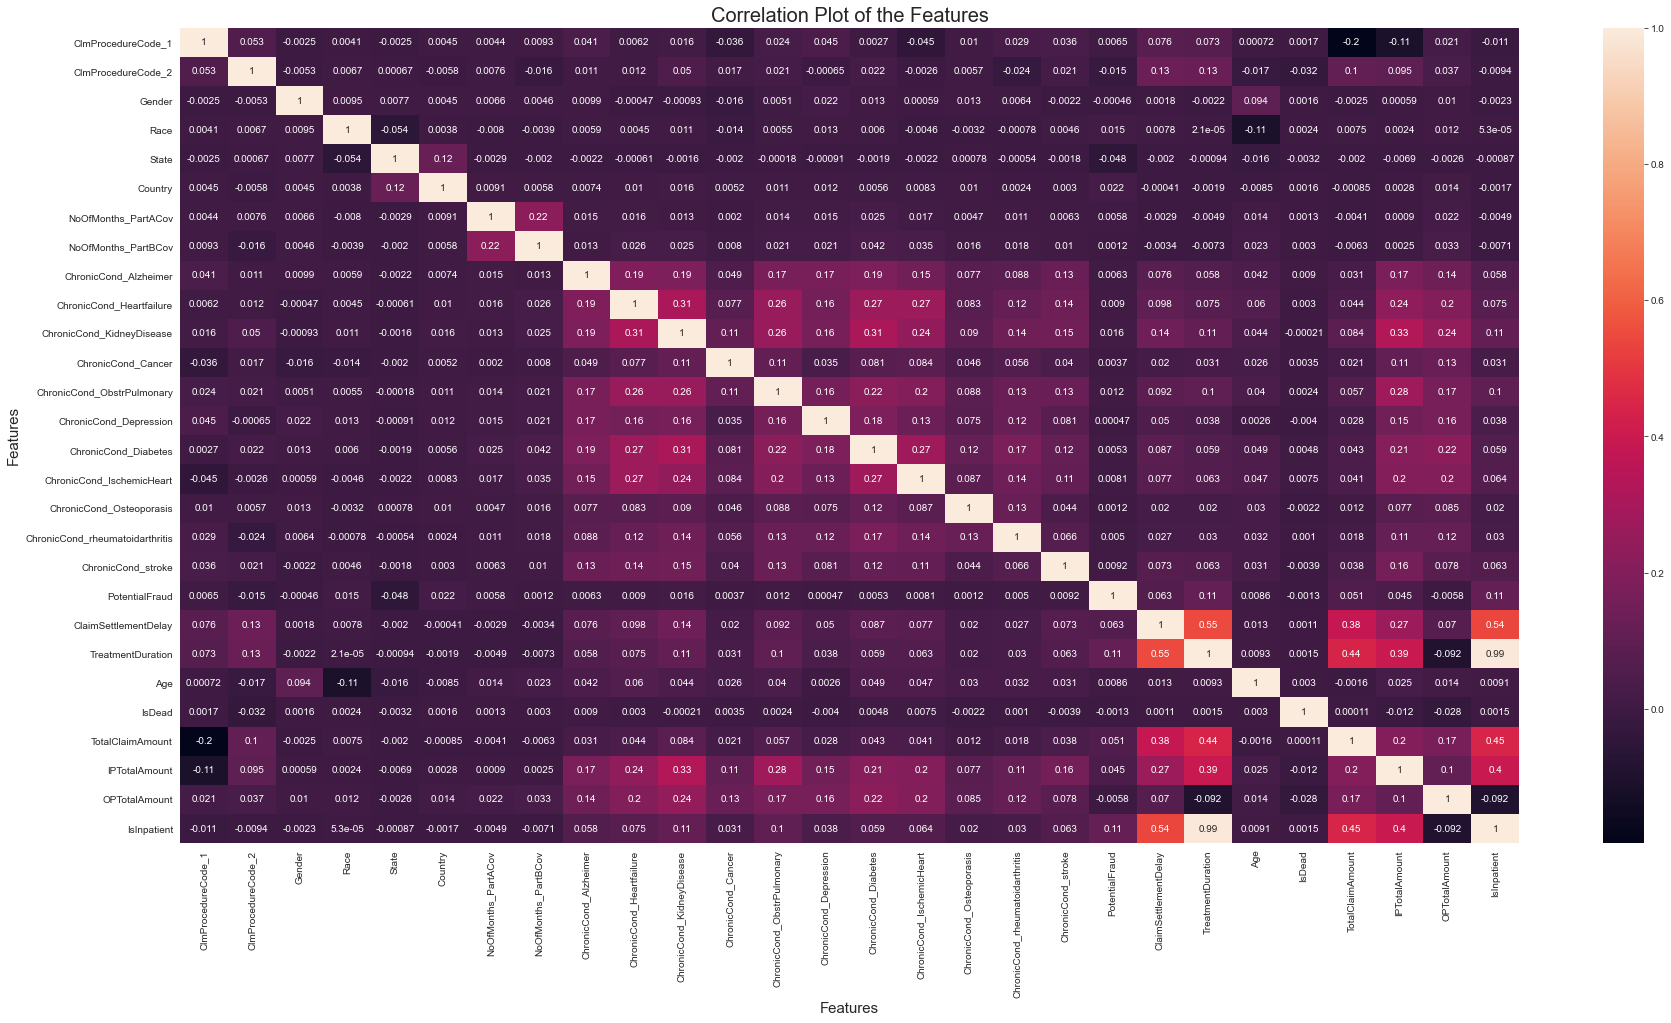

Wall time: 8.55 s


In [ ]:
%%time
# Plotting the correlation Plot to see the correlated features
plt.figure(figsize=(30,15))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.title('Correlation Plot of the Features', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

#### Observation

* The features 'IsInpatient' and 'TreatmentDuration' are highly correlated with a Spearman Rank Correlation Coefficient of 0.99.
* Hence, the new feature 'IsInpatient' does not add much value and can be removed.

In [ ]:
data.drop(columns='IsInpatient', inplace=True)

* ClaimID, BeneID and Provider are just unique identifiers and won't contribute anything to do the classification. Hence, those can be removed.
* Based on the EDA (Count Plot) performed before, we can remove the features 'NoOfMonths_PartACov' and 'NoOfMonths_PartBCov' because more than 99% of the values have one value and it won't add much value to the classification task.

In [ ]:
data.drop(columns=['ClaimID', 'BeneID', 'Provider', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], inplace=True)

In [ ]:
print('Shape of the Dataframe:', data.shape)

Shape of the Dataframe: (558211, 41)


### <font color="blue">3.3.4. New Features from the Physician related features</font>

* We will derive new features from the features 'AttendingPhysician', 'OperatingPhysician' and 'OtherPhysician' as:<br>
&emsp; 1. UniquePhysCount: Number of different physicians who attended/operated the patient and/or performed any other work in a claim record.<br>
&emsp; 2. PhysRoleCount: Total number of attending, operating and other physicians who worked for a patient in a claim record.<br>
&emsp; 3. IsSamePhysMultiRole1: Flag to indicate if a single physician is involved with multiple roles for a patient in a claim record.<br>
&emsp; 4. IsSamePhysMultiRole2: Flag to indicate if there are only two physicians involved in a claim record and one of them had multiple roles.<br>
* Consider the below table data to understand it better:

|AttendingPhysician|OperatingPhysician|OtherPhysician|UniquePhysCount|PhysRoleCount|IsSamePhysMultiRole1|IsSamePhysMultiRole2|
|----|----|----|----|----|----|----|
|PHY01|PHY02|PHY03|3|3|0|0|
|PHY01|PHY02|-|2|2|0|0|
|PHY01|-|-|1|1|0|0|
|PHY01|PHY01|-|1|2|1|0|
|PHY01|PHY01|PHY01|1|3|1|0|
|PHY01|PHY01|PHY02|2|3|0|1|

In [17]:
# Fetch the columns related to Physicians
colPhys = [col for col in data.columns if 'Physician' in col]

colPhys

['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']

In [18]:
%%time
# Prepare the feature 'UniquePhysCount'
data['UniquePhysCount'] = data[colPhys].apply(lambda x: len(set([phys for phys in x if not pd.isnull(phys)])), axis=1)

CPU times: user 6.22 s, sys: 81.3 ms, total: 6.3 s
Wall time: 6.3 s


In [19]:
%%time
# Prepare the feature 'PhysRoleCount'
data['PhysRoleCount'] = data[colPhys].apply(lambda x: len([phys for phys in x if not pd.isnull(phys)]), axis=1)

CPU times: user 6 s, sys: 77.2 ms, total: 6.08 s
Wall time: 6.09 s


In [20]:
%%time
# Prepare the feature 'IsSamePhysMultiRole1'
data['IsSamePhysMultiRole1'] = data[['UniquePhysCount','PhysRoleCount']] \
                                .apply(lambda x: 1 if x['UniquePhysCount'] == 1 and x['PhysRoleCount'] > 1 else 0, axis=1)

CPU times: user 7.68 s, sys: 79.2 ms, total: 7.76 s
Wall time: 7.74 s


In [21]:
%%time
# Prepare the feature 'IsSamePhysMultiRole2'
data['IsSamePhysMultiRole2'] = data[['UniquePhysCount','PhysRoleCount']] \
                                .apply(lambda x: 1 if x['UniquePhysCount'] == 2 and x['PhysRoleCount'] > 2 else 0, axis=1)

CPU times: user 6.6 s, sys: 61.9 ms, total: 6.67 s
Wall time: 6.66 s


#### <font color="blue">3.3.4.1. New Encoded Features from the Physician related features</font>

* Here, we will create 3 new features by encoding the number of times they appear on each of the 'AttendingPhysician', 'OperatingPhysician' and 'OtherPhysician' features.

In [ ]:
print('Most occurring physician in all the Physician Features\' top 10 physicians, '
      'along with their count across all Features:\n', \
     topKCommonCodes(dataClaim, colPhys, 10))

  0%|          | 0/3 [00:00<?, ?it/s]

Most occurring physician in all the Physician Features' top 10 physicians, along with their count across all Features:
 {'PHY412132': 3, 'PHY337425': 3, 'PHY330576': 2, 'PHY350277': 2, 'PHY423534': 2, 'PHY314027': 2, 'PHY327046': 2, 'PHY338032': 2, 'PHY357120': 2, 'PHY341578': 2}


* Based on the EDA done on the Physician features, we saw that<br>
&emsp; i. Physician 'PHY412132' was an other physician for most of the patients. Hence, we will include it as a new encoded features.<br>
&emsp; ii. Physician 'PHY330576' attended and operated most of the patients.<br>
* Based on the stats of the top 10 physicians listed above, we will consider the top 3 physicians.
* 2 among the top 3 are already considered from the EDA analysis as well.
* Taking the 3rd physician as 'PHY337425' which has the highest occurence of 3.
* Hence, we will create 3 new encoded features: 'PHY412132', 'PHY337425', 'PHY330576'. These features will be encoded with a value indicating how many times they appeared as attending, operating or other physician in a claim record.

* Consider the below table data to understand it better:

|AttendingPhysician|OperatingPhysician|OtherPhysician|PHY412132|PHY337425|PHY330576|
|----|----|----|----|----|----|
|PHY412132|PHY337425|PHY337425|1|2|0|
|PHY330576|PHY412132|-|1|0|1|
|PHY330576|-|-|0|0|1|
|PHY337425|PHY337425|-|0|2|0|
|PHY412132|PHY412132|PHY412132|3|0|0|
|PHY330576|PHY337425|PHY412132|1|1|1|

In [63]:
def encodedFeatures(dataset, existingFeatures, newFeatures, suffix=''):
    '''
    Function to create new encoded features based on their count of values in the existing set of features
    
    Parameters:
    ----------
    dataset: pandas.core.frame.DataFrame
        DataFrame containing the data for which the new set of encoded features has to be created.
    exsitingFeatures: list
        List of existing features to considered for counting.
    newFeatures: list
        List of new features to encoded and created
    suffix: str
        Suffix to add before the new feature names.
    '''
    
    # Fetch the number of datapoints in the given dataset
    lenDatapoints = dataset.shape[0]
    
    # Iterate through each of the new features:
    for newFeature in tqdm(newFeatures):
        
        listCount = list() # List to store the encoded values (count) for a new feature.
        
        # Iterate through each dataset and perform the logic to count.
        for i in tqdm(range(lenDatapoints)):
            
            listCount.append(list(dataset[existingFeatures].iloc[i].values).count(newFeature))
        
        dataset[suffix + newFeature] = listCount
        
    return dataset

* Note: The encoding of features takes around 2 hours for each feature using the above function.
* Optimized the above function to use list instead of direct operations on a Dataframe and it helped reduce the processing time a lot.

In [4]:
def encodeCatFeatures(dataset, existingFeatures, newFeatures, suffix=''):
    '''
    Function to create new encoded features for Categorical Features, based on their count of values 
        in the existing set of features.

    Parameters:
    ----------
    dataset: pandas.core.frame.DataFrame
        DataFrame containing the data for which the new set of encoded features has to be created.
    exsitingFeatures: list
        List of existing features to considered for counting.
    newFeatures: list
        List of new features to encoded and created
    suffix: str
        Suffix to add before the new feature names.
    '''
    
    # Fetch the number of datapoints in the given dataset
    lenDatapoints = dataset.shape[0]
    
    # Iterate through each of the new features:
    for newFeature in tqdm(newFeatures):

        listIsExistAllFeatures = list() # List to store a list of 0s and 1s for each existing feature,
        # if the new feature value exist in the existing features.

        # Iterate through each of the existing feature set and perform the logic to count.
        for existingFeature in existingFeatures:
            
            listIsExist = list() # List to store '1' if the new feature value exist in the existing feature.
            
            for value in list(dataset[existingFeature]):
                
                if str(value) == str(newFeature):
                    
                    listIsExist.append(1)
                
                else:
                    
                    listIsExist.append(0)
                    
            listIsExistAllFeatures.append(listIsExist)
            
        arrayCount = np.zeros(lenDatapoints) # Array to store the count of the existing features containing the new features.
        
        # Iterate through each of the list in 'listIsExistAllFeatures' and sum the counts.
        for i in range(0, len(listIsExistAllFeatures)):
            
            arrayCount = arrayCount + np.array(listIsExistAllFeatures[i])

        dataset[suffix + newFeature] = arrayCount.astype(int)

    return dataset

In [22]:
%%time

# Call the encodedFeatures function to generate new features 'PHY412132'
#data = encodedFeatures(data, colPhys, ['PHY412132'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/558211 [00:00<?, ?it/s]

CPU times: user 2h 6min 4s, sys: 2min 9s, total: 2h 8min 14s
Wall time: 2h 6min 50s


In [24]:
%%time

# Call the encodedFeatures function to generate new features 'PHY337425'
#data = encodedFeatures(data, colPhys, ['PHY337425'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/558211 [00:00<?, ?it/s]

CPU times: user 2h 10min 27s, sys: 2min 14s, total: 2h 12min 41s
Wall time: 2h 11min 9s


In [27]:
%%time

# Call the encodedFeatures function to generate new feature 'PHY330576'
#data = encodedFeatures(data, colPhys, ['PHY330576'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/558211 [00:00<?, ?it/s]

CPU times: user 1h 54min 56s, sys: 1min 53s, total: 1h 56min 50s
Wall time: 1h 55min 35s


In [ ]:
%%time

# Call the encodedFeatures function to generate new features: 'PHY412132', 'PHY337425', 'PHY330576'
data = encodeCatFeatures(data, colPhys, ['PHY412132', 'PHY337425', 'PHY330576'])
# This is very fast

In [24]:
# Now remove the original features related to the Physicians
data.drop(columns=['AttendingPhysician','OperatingPhysician','OtherPhysician'], inplace=True)

In [26]:
print('Shape of the Dataset after removal of original physician related features and introduction of new physician related columns: ', data.shape)

Shape of the Dataset after removal of original physician related features and introduction of new physician related columns:  (558211, 45)


### <font color="blue">3.3.5. New Features from the Claim Diagnosis Codes related features</font>

* Here, we will create 7 new encoded features from all the Claim Diagnosis Codes, which are the top codes among them.
* Also, we will replace the value of each existing Claim Diagnosis Codes features with a flag to indicate whether a value exists or not.

In [ ]:
# Fetch the columns related to the Claims Diagnosis Codes
colDiagCode = [col for col in data.columns if 'ClmDiagnosisCode' in col]

colDiagCode

In [ ]:
print('Most occurring codes in all the Claim Diagnosos Codes Features\' top 10 codes, '
      'along with their count across all Features:\n', \
     topKCommonCodes(data, colDiagCode, 10))

  0%|          | 0/10 [00:00<?, ?it/s]

Most occurring codes in all the Claim Diagnosos Codes Features' top 10 codes, along with their count across all Features:
 {'4019': 10, '2724': 10, '42731': 10, '25000': 9, '2449': 9, '53081': 8, '4280': 8, '2720': 6, '41401': 6, 'V5869': 5}


* Take the top 7 codes from the above result because the top 7 codes occur in atleast 8 Diagnosis Codes features.
* Hence, new encoded features will be created for:<br>
&emsp; * '4019', '2724', '42731', '25000', '2449', '53081', '4280'

In [68]:
# Call the encodedFeatures function to generate new feature for the top 7 Claim Diagnosis Codes
data = encodeCatFeatures(data, colDiagCode, ['4019', '2724', '42731', '25000', '2449', '53081', '4280'], 'ClmDiagCode_')

In [70]:
# For each of the Claim Diagnosis Code Features, replace the values with 1 if there is a value, else replace with 0 .
for diagCode in tqdm(colDiagCode):
    data[diagCode] = data[diagCode].apply(lambda x: 1 if not pd.isnull(x) else 0)

  0%|          | 0/10 [00:00<?, ?it/s]

In [72]:
print('Shape of the Dataset after adding new features and modifying existing features related to the' \
      'Claim Diagnosis Code Features :\n', data.shape)

Shape of the Dataset after adding new features and modifying existing features related to theClaim Diagnosis Code Features :
 (558211, 52)


### <font color="blue">3.3.6. New Features from the Claim Procedure Codes related features</font>

* Here, we will create 5 new encoded features from all the Claim Procedure Codes, which are the top codes among them.
* Also, we will replace the value of each existing Claim Procedure Codes features with a flag to indicate whether a value exists or not.

In [85]:
# Fetch the columns related to the Claims Procedure Codes
colProcCode = [col for col in data.columns if 'Procedure' in col]

colProcCode

['ClmProcedureCode_1', 'ClmProcedureCode_2']

In [ ]:
print('Most occurring codes in all the Claim Diagnosos Codes Features\' top 10 codes, '
      'along with their count across all Features:\n', \
     topKCommonCodes(data, colProcCode, 10))

  0%|          | 0/2 [00:00<?, ?it/s]

Most occurring codes in all the Claim Diagnosos Codes Features' top 10 codes, along with their count across all Features:
 {9904.0: 1, 8154.0: 1, 66.0: 1, 3893.0: 1, 3995.0: 1, 4516.0: 1, 3722.0: 1, 8151.0: 1, 8872.0: 1, 9671.0: 1}


* Take the top 5 codes from the above result.
* Hence, new encoded features will be created for:<br>
&emsp; * '9904.0', '8154.0', '66.0', '3893.0, '3995.0'

In [75]:
# Call the encodeCatFeatures function to generate new feature for the top 5 Claim Procedure Codes
data = encodeCatFeatures(data, colProcCode, ['9904.0', '8154.0', '66.0', '3893.0', '3995.0'], 'ClmProcCode_')

In [86]:
%%time
# For each of the Claim Procedure Code Features, replace the values with 1 if there is a value, else replace with 0 .
for procCode in tqdm(colProcCode):
    data[procCode] = data[procCode].apply(lambda x: 1 if not pd.isnull(x) else 0)

  0%|          | 0/2 [00:00<?, ?it/s]

Wall time: 2 s


In [88]:
print('Shape of the Dataset after adding new features and modifying existing features related to the' \
      'Claim Procedure Code Features :\n', data.shape)

Shape of the Dataset after adding new features and modifying existing features related to theClaim Procedure Code Features :
 (558211, 57)


### <font color="blue">3.3.7. Update ClmAdmitDiagnosisCode and DiagnosisGroupCode Features</font>

* Here, we will replace the value of the features with a flag to indicate whether a value exists or not.

In [91]:
%%time
# For each of the Claim Admit Diagnosis Code and Diagnosis Group Code Features, 
# replace the values with 1 if there is a value, else replace with 0 .
for code in tqdm(['ClmAdmitDiagnosisCode', 'DiagnosisGroupCode']):
    data[code] = data[code].apply(lambda x: 1 if not pd.isnull(x) else 0)

  0%|          | 0/2 [00:00<?, ?it/s]

Wall time: 1.79 s


In [93]:
print('Shape of the Dataset after modifying existing ClmAdmitDiagnosisCode and DiagnosisGroupCode Feature values:\n',
      data.shape)

Shape of the Dataset after modifying existing ClmAdmitDiagnosisCode and DiagnosisGroupCode Feature values:
 (558211, 57)


### <font color="blue">2.3.8. Gender</font>

* Gender feature has two values 1 and 2.
* Replace the value of 2 with 0.

In [8]:
data['Gender'].replace(to_replace=2, value=0, inplace=True)

In [10]:
# Save the dataset
data.to_csv('Data/data.csv', index=False)

### <font color="blue">2.3.9. New Features for State and Country</font>

* We will do the below two kinds of encoding for the 'State' and 'Country' features, after splitting the data into train, test and CV:<br>
&emsp; 1. Response Encoding: will be used in the models suitable for lower dimensions like Decision Tree, Random Forest, GBDT, etc.<br>
&emsp; 2. One-hot Encoding: for model suitable for handling large dimensions as well. Eg., Naive Baiyes, Logistic Regression, etc.

----

## <font color="blue">3.4. Plotting the correlation plot of the features after all the feature engineering</font>

* We will plot the **Spearman Rank Correlation Coefficient** Graph for the final dataset prepared and see if any features can be removed based on the Correlation Coefficient.
* Will consider the correlation coefficient of threshold 0.70.
* Will check for the pair of features having correlation coefficient greater than 0.70.
* Out of the two features in a pair, we will remove the feature having lesser correlation coefficient with the Class Label 'PotentialFraud'.

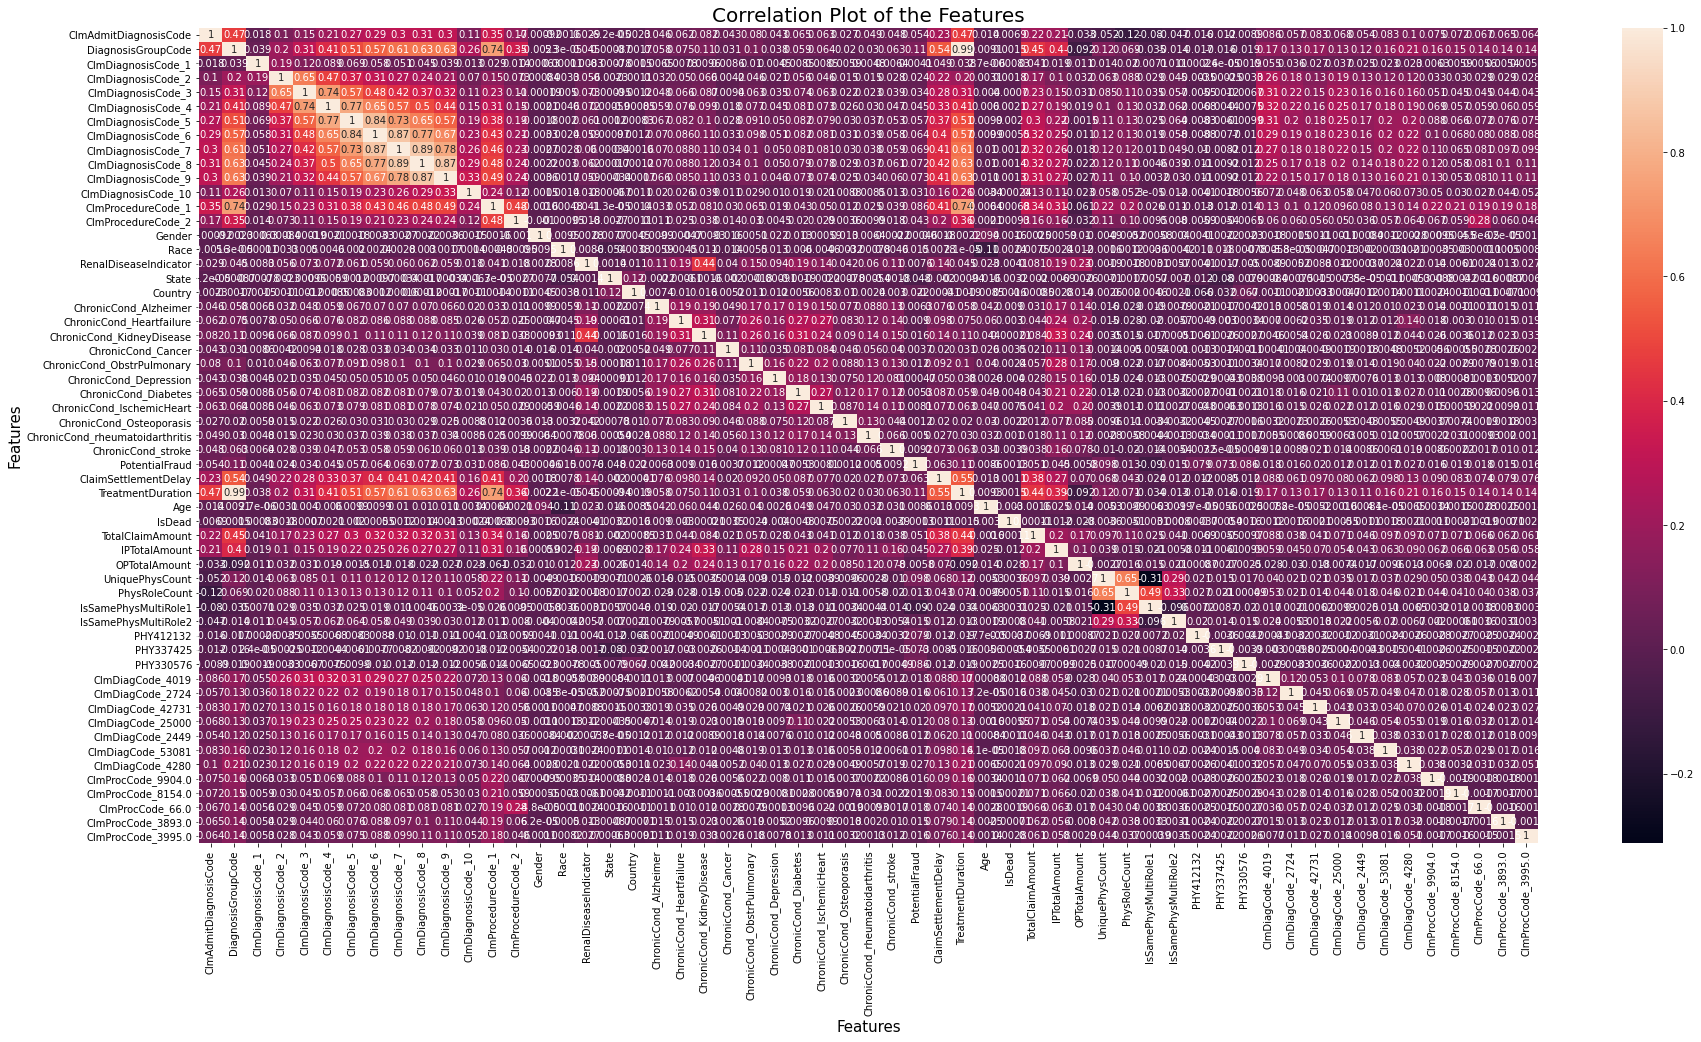

Wall time: 1min 19s


In [96]:
%%time
plt.figure(figsize=(30,15))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.title('Correlation Plot of the Features', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

#### Observation from the Correlation Graph

* Here, we see there are few features having high Spearman Correlation Coefficient.
* Spearman Correlation Coefficient between some of the features having coefficient greater than 0.70 are:<br>
&emsp; 1. TreatmentDuration and DiagnosisGroupCode: 0.99<br>
&emsp; 2. TreatmentDuration and ClmProcedureCode_1: 0.74<br>
&emsp; 3. DiagnosisGroupCode and ClmProcedureCode_1: 0.74<br>
&emsp; 4. ClmDiagnosisCode_3 and ClmDiagnosisCode_4: 0.74<br>
&emsp; 5. ClmDiagnosisCode_4 and ClmDiagnosisCode_5: 0.77<br>
&emsp; 6. ClmDiagnosisCode_5 and ClmDiagnosisCode_6: 0.84<br>
&emsp; 7. ClmDiagnosisCode_5 and ClmDiagnosisCode_7: 0.73<br>
&emsp; 8. ClmDiagnosisCode_6 and ClmDiagnosisCode_7: 0.87<br>
&emsp; 9. ClmDiagnosisCode_6 and ClmDiagnosisCode_8: 0.77<br>
&emsp; 10. ClmDiagnosisCode_7 and ClmDiagnosisCode_8: 0.89<br>
&emsp; 11. ClmDiagnosisCode_7 and ClmDiagnosisCode_9: 0.78<br>
&emsp; 12. ClmDiagnosisCode_8 and ClmDiagnosisCode_9: 0.87<br>

#### Removal of features
* Will remove one of the features among these pairs that has lesser correlation coefficient with the Class Label 'PotentialFraud'.
* Correlation Coefficient of the Feature with the Class Label is shown in parenthesis.
* Removing the below feature among the pair of features based on the correlation coefficient with the Class Label:<br>
&emsp; 1. TreatmentDuration (0.11) and DiagnosisGroupCode (0.11): Any feature can be removed as both have a correlation coefficient of 0.11 with the Class Label. Remove the feature 'DiagnosisGroupCode' here.<br>
&emsp; 2. TreatmentDuration (0.11) and ClmProcedureCode_1 (0.086): Remove the feature 'ClmProcedureCode_1'.<br>
&emsp; 3. DiagnosisGroupCode (0.11) and ClmProcedureCode_1 (0.086): Both these features are already accounted for removal.<br>
&emsp; 4. ClmDiagnosisCode_3 (0.034) and ClmDiagnosisCode_4 (0.045): Remove the feature 'ClmDiagnosisCode_3'.<br>
&emsp; 5. ClmDiagnosisCode_4 (0.045) and ClmDiagnosisCode_5 (0.057): Remove the feature 'ClmDiagnosisCode_4'.<br>
&emsp; 6. ClmDiagnosisCode_5 (0.057) and ClmDiagnosisCode_6 (0.064): Remove the feature 'ClmDiagnosisCode_5'.<br>
&emsp; 7. ClmDiagnosisCode_5 (0.057) and ClmDiagnosisCode_7 (0.069): 'ClmDiagnosisCode_5' has the lesser coefficient and is already accounted in the above point.<br>
&emsp; 8. ClmDiagnosisCode_6 (0.064) and ClmDiagnosisCode_7 (0.069): Remove the feature 'ClmDiagnosisCode_6'.<br>
&emsp; 9. ClmDiagnosisCode_6 (0.064) and ClmDiagnosisCode_8 (0.072): 'ClmDiagnosisCode_6' has the lesser coefficient and is already accounted in the above point.<br>
&emsp; 10. ClmDiagnosisCode_7 (0.069) and ClmDiagnosisCode_8 (0.072): Remove the feature 'ClmDiagnosisCode_7'.<br>
&emsp; 11. ClmDiagnosisCode_7 (0.069) and ClmDiagnosisCode_9 (0.073): 'ClmDiagnosisCode_7' has the lesser coefficient and is already accounted in the above point.<br>
&emsp; 12. ClmDiagnosisCode_8 (0.072) and ClmDiagnosisCode_9 (0.073): Remove the feature 'ClmDiagnosisCode_8'.<br>

In [12]:
# Remove the above set of features from the dataset
data.drop(columns=['DiagnosisGroupCode', 'ClmProcedureCode_1', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                   'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
                ], inplace=True)

In [13]:
# Save the dataset
data.to_csv('Data/finalData.csv', index=False)

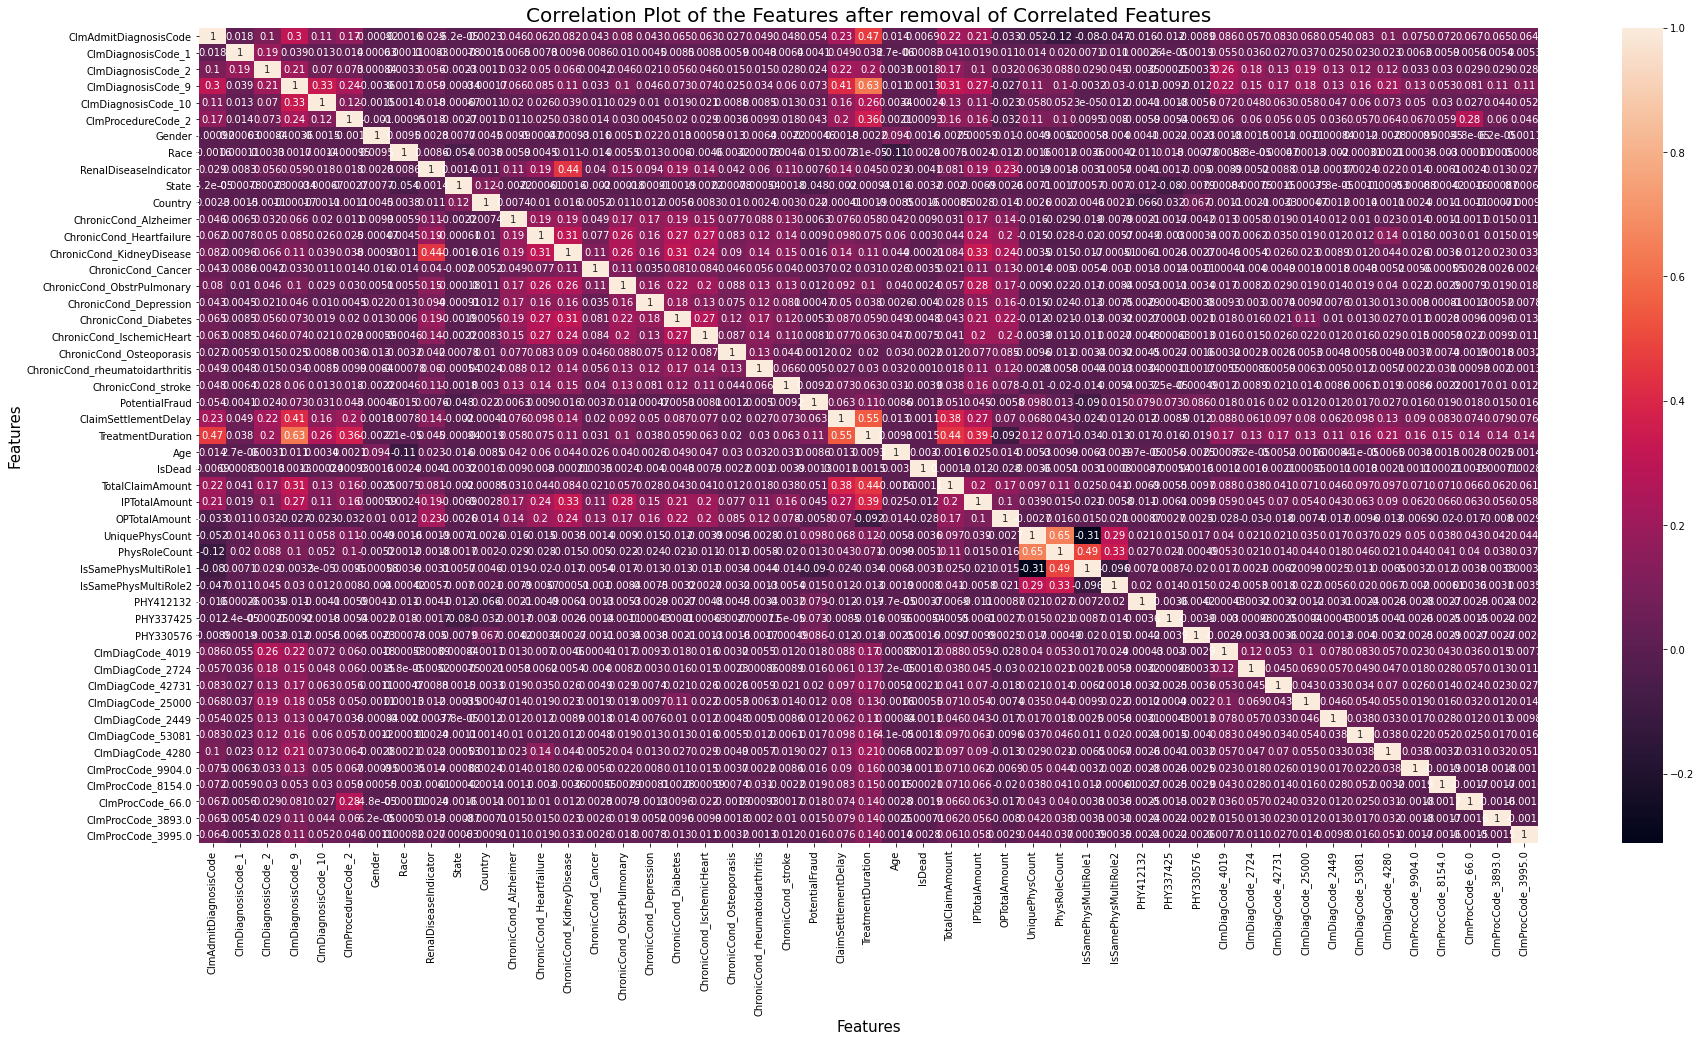

Wall time: 57.7 s


In [20]:
%%time
# Plot the Correlation Graph after removal of correlated features
plt.figure(figsize=(30,15))
sns.heatmap(data.corr(method='spearman'), annot=True)
plt.title('Correlation Plot of the Features after removal of Correlated Features', fontsize=20)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.show()

#### Observation

* As we can see that now no two features have a correlation coefficient greater than 0.70.
* This implies that there are no more highly correlated features (coefficient > 0.70).

In [14]:
print('Shape of the Dataset after removal of highly correlated features (including Class Label):', data.shape)

Shape of the Dataset after removal of highly correlated features (including Class Label): (558211, 49)


In [15]:
# Display the features
data.columns # PotentialFraud is the Class Label here.

Index(['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_2',
       'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'Country',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'PotentialFraud', 'ClaimSettlementDelay',
       'TreatmentDuration', 'Age', 'IsDead', 'TotalClaimAmount',
       'IPTotalAmount', 'OPTotalAmount', 'UniquePhysCount', 'PhysRoleCount',
       'IsSamePhysMultiRole1', 'IsSamePhysMultiRole2', 'PHY412132',
       'PHY337425', 'PHY330576', 'ClmDiagCode_4019', 'ClmDiagCode_2724',
       'ClmDiagCode_42731', 'ClmDiagCode_25000', 'ClmDiagCode_2449',
       'ClmDiagCode_53081', 'ClmDiagCode_4280'

In [16]:
# Display top 5 records
data.head()

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_2,Gender,Race,RenalDiseaseIndicator,State,Country,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,PotentialFraud,ClaimSettlementDelay,TreatmentDuration,Age,IsDead,TotalClaimAmount,IPTotalAmount,OPTotalAmount,UniquePhysCount,PhysRoleCount,IsSamePhysMultiRole1,IsSamePhysMultiRole2,PHY412132,PHY337425,PHY330576,ClmDiagCode_4019,ClmDiagCode_2724,ClmDiagCode_42731,ClmDiagCode_25000,ClmDiagCode_2449,ClmDiagCode_53081,ClmDiagCode_4280,ClmProcCode_9904.0,ClmProcCode_8154.0,ClmProcCode_66.0,ClmProcCode_3893.0,ClmProcCode_3995.0
0,1,1,1,1,0,0,1,1,0,39,230,1,0,1,0,0,1,1,1,0,1,1,1,6,6,67,0,27068,39204,130,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,1,1,0,39,310,1,1,1,0,0,0,0,1,0,0,0,1,0,0,78,0,50,26136,650,2,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,1,1,1,1,0,1,0,1,0,39,230,1,1,1,0,1,0,0,1,0,0,0,1,12,12,96,0,20068,20068,120,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,1,1,0,39,600,0,0,0,0,0,0,0,1,1,0,0,1,18,18,87,0,18068,18068,1590,1,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,1,0,39,280,0,1,0,0,1,0,1,1,1,1,0,1,4,4,80,0,14068,29136,610,3,3,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


----

----